In [63]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
import numpy as np
import tensorflow as tf
from keras.applications import vgg19

base_image_path = keras.utils.get_file("londra.jpg", "https://res.cloudinary.com/drslyomqm/image/upload/v1715716255/samples/resimler/londra_dmw05v.jpg")
style_reference_image_path = keras.utils.get_file(
    "ciglik.jpg", "https://res.cloudinary.com/drslyomqm/image/upload/v1715716255/samples/resimler/ciglik_apdauk.jpg"
)
result_prefix = "londra_generated"

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Dimensions of the generated picture.
width, height = keras.utils.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)


Temel (içerik) görselimize ve stil referans görselimize bir göz atalım

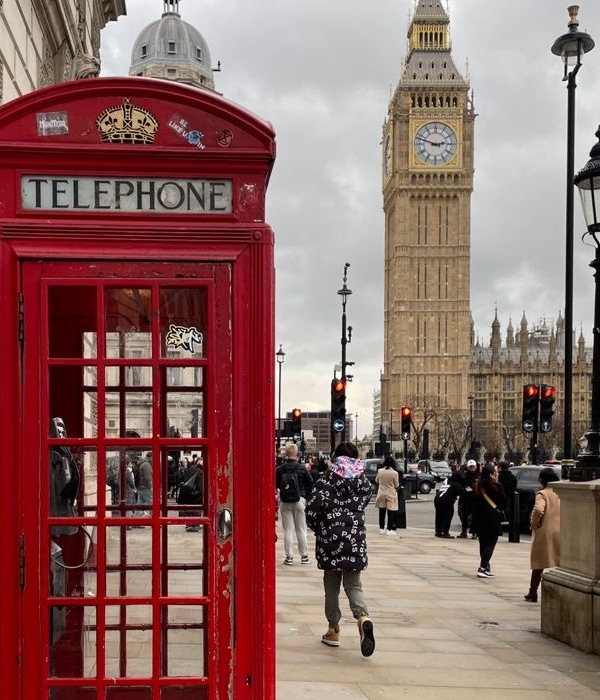

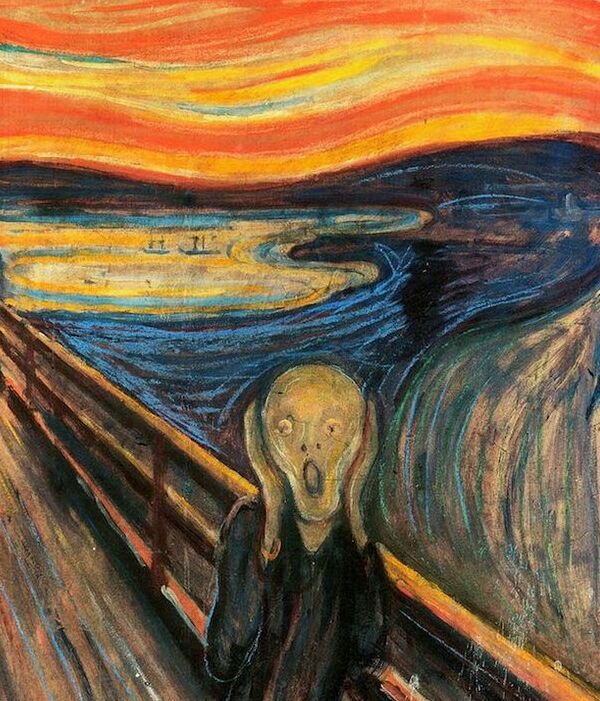

In [64]:
from IPython.display import Image, display

display(Image(base_image_path))
display(Image(style_reference_image_path))

Görüntü ön işleme / işlemden çıkarma yardımcı programları

In [65]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.utils.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x


**Stil transfer kaybını hesaplayalım**
İlk olarak, 4 yardımcı fonksiyon tanımlamamız gerekiyor:


* gram_matrix (stil kaybını hesaplamak için kullanılır)

* Oluşturulan görüntüyü stil referans görüntüsünün yerel dokularına yakın tutan style_loss işlevi

* Oluşturulan görüntünün üst düzey temsilini temel görüntününkine yakın tutan content_loss işlevi

* Total_variation_loss fonksiyonu, oluşturulan görüntüyü yerel olarak tutarlı tutan bir düzenleme kaybıdır




In [66]:
# The gram matrix of an image tensor (feature-wise outer product)


def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))


Ardından, VGG19'un ara aktivasyonlarını alan bir özellik çıkarma modeli oluşturalım.

In [67]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)


Son olarak, işte stil aktarım kaybını hesaplayan kod.


In [68]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

**Kayıp ve gradyan hesaplamasına bir tf.function dekoratörü ekleyelim**
Derlemek ve böylece daha hızlı hale getirmek için.


In [69]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

**Eğitim döngüsü**
Kaybı en aza indirmek için vanilya gradyan inişi adımlarını tekrar tekrar çalıştıralım ve elde edilen görüntüyü her 100 yinelemede bir kaydedelim.
Öğrenme oranını her 100 adımda bir 0,96 oranında azaltıyoruz.

In [70]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 8000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.utils.save_img(fname, img)

Iteration 100: loss=2804.93
Iteration 200: loss=1912.41
Iteration 300: loss=1585.02
Iteration 400: loss=1411.08
Iteration 500: loss=1301.89
Iteration 600: loss=1226.00
Iteration 700: loss=1169.74
Iteration 800: loss=1126.29
Iteration 900: loss=1091.36
Iteration 1000: loss=1062.65
Iteration 1100: loss=1038.69
Iteration 1200: loss=1018.45
Iteration 1300: loss=1000.92
Iteration 1400: loss=985.54
Iteration 1500: loss=971.96
Iteration 1600: loss=959.83
Iteration 1700: loss=948.97
Iteration 1800: loss=939.20
Iteration 1900: loss=930.36
Iteration 2000: loss=922.34
Iteration 2100: loss=914.98
Iteration 2200: loss=908.20
Iteration 2300: loss=901.97
Iteration 2400: loss=896.26
Iteration 2500: loss=890.99
Iteration 2600: loss=886.11
Iteration 2700: loss=881.61
Iteration 2800: loss=877.41
Iteration 2900: loss=873.49
Iteration 3000: loss=869.85
Iteration 3100: loss=866.43
Iteration 3200: loss=863.23
Iteration 3300: loss=860.24
Iteration 3400: loss=857.42
Iteration 3500: loss=854.76
Iteration 3600: 

4000 iterasyondan sonra aşağıdaki sonucu elde edeceğiz:


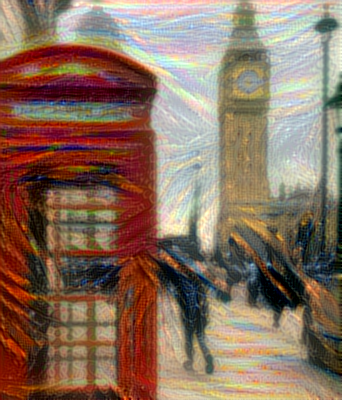

In [71]:
display(Image(result_prefix + "_at_iteration_8000.png"))
